 # Notebook for calculating and evaluating the trust score 
 Made by Sarah de Boer. Inspired by Jiang et al, 2018. 
 
 For the image and mmbt models different scripts are needed to extract the features from the files. 

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from trustscore.trustscore import TrustScore, KNNConfidence
from trustscore.trustscore_evaluation import plot_precision_curve

import os

## Arguments
1. Change the model to either img or mmbt
2. Change name to the name of the model directory. 
3. Change savedir to the full path the model is stored in.
4. Change task to either cartridge_case or cartridge_case_full. 

In [256]:
class Args:
    batch_sz = 1
    bert_model = "bert-base-uncased"
    data_path = "/Users/sarahdeboer/Data_thesis/"
    device = 'cpu'
    drop_img_percent = 0.0
    dropout = 0.1
    embed_sz = 300
    freeze_img = 3
    freeze_txt = 5
    glove_path = "/path/to/glove_embeds/glove.840B.300d.txt"
    gradient_accumulation_steps = 40
    hidden = []
    hidden_sz = 768
    img_embed_pool_type = "avg"
    img_hidden_sz = 512
    include_bn = True
    lr = 5e-05
    lr_factor = 0.5
    lr_patience = 2
    max_epochs = 100
    max_seq_len = 512
    model = "img"
    n_classes = 8
    n_workers = 4
    name = "img-resnet18_full_data_16_cat_model_run"
    num_image_embeds = 3
    patience = 5
    savedir = '/Users/sarahdeboer/Data_thesis/models_mmbt/nieuw/img/img-resnet18_full_data_16_cat_model_run/'
    seed = 1
    task = "cartridge_case"
    task_type = "classification"
    warmup = 0.1
    weight_classes =1

args=Args()

In [3]:
CATEGORY_MAPPING = {
    '9mm Luger, Glock, Gen 1-4, S&W SW9F' : 0,
    '7.62 x 39 mm, Kalashnikov' : 1,
    '7.65 Br., Skorpion' : 2,
    '9mm Luger, Ceska Zbrojovka, 75/85' : 3,
    '6.35 Br., Tanfoglio, GT-28' : 4,
    '9mm Luger, Beretta/Taurus, 92' : 5,
    '9mm Luger, Zastava, M70/88' : 6,
}

## Open the files
- The predictions for the test set
- The train/test embeddings and the train/test target labels. 

In [257]:
with open(os.path.join(args.savedir, "test_labels_pred.txt"), "r") as f:
    predictions = f.readlines()
    predictions = [int(p.rstrip('\n')) for p in predictions] 

In [258]:
train_embeddings = np.load(os.path.join(args.savedir,'train_embeddings.npy'))
train_targets = np.load(os.path.join(args.savedir,'train_targets2.npy'))
train_predictions = np.load(os.path.join(args.savedir,'train_predictions.npy'))

test_embeddings = np.load(os.path.join(args.savedir, 'test_embeddings.npy'))
test_targets = np.load(os.path.join(args.savedir, 'test_targets.npy'))

train_input_images = np.load(os.path.join(args.savedir, 'train_input_images_flattened.npy'))
test_input_images = np.load(os.path.join(args.savedir, 'input_images_flattened.npy'))

## Image model 
The image model has train embeddings of shape (batch_sz, 3, 512). We take the first of the color channels because we have BW images and reshape it to (batch_sz, 512) to have for each sample a vector of 512. 

### Load the shap vectors
For the train and test set we load the calculated shapley vectors and reshape them to match the embeddings shapes. 

In [259]:
# img model
train_embeddings = train_embeddings[:,0,:].reshape(train_embeddings.shape[0], train_embeddings.shape[2])
test_embeddings = test_embeddings[:,0,:].reshape(test_embeddings.shape[0], test_embeddings.shape[2])

train_targets = train_targets.reshape(train_targets.shape[0])
# train_predictions = train_predictions.reshape(train_predictions[0])
test_targets = test_targets.reshape(test_targets.shape[0])

# shap vectors for train set
shap_vectors_train = np.load(os.path.join(args.savedir, 'shap_vector_train.npy'))

shap_vectors_train = shap_vectors_train[:,:,0,:].reshape(shap_vectors_train.shape[0],shap_vectors_train.shape[1],shap_vectors_train.shape[3])

# shap vectors for test set
shap_vectors_test = np.load(os.path.join(args.savedir, 'shap_vector_test.npy'))

shap_vectors_test = shap_vectors_test[:,:,0,:].reshape(shap_vectors_test.shape[0],shap_vectors_test.shape[1],shap_vectors_test.shape[3])

## MMBT model
The MMBT model has embeddings of shape (batch_sz, 1, 768). We reshape them to have shape (batch_sz, 768). 

### Load shap vector 
For the train and test set we load the shapley values. And reshape them to match the shape of the embeddings. 

In [217]:
# mmbt
train_embeddings = train_embeddings #.reshape(train_embeddings.shape[0], train_embeddings.shape[2])
test_embeddings = test_embeddings #.reshape(test_embeddings.shape[0], test_embeddings.shape[2])

train_targets = train_targets.reshape(train_targets.shape[0])
train_predictions = train_predictions.reshape(train_predictions.shape[0])
test_targets = test_targets.reshape(test_targets.shape[0])

#shap vectors for train set
shap_vectors_train = np.load(os.path.join(args.savedir, 'shap_vector_train.npy'))

shap_vectors_train = shap_vectors_train.reshape(shap_vectors_train.shape[0],shap_vectors_train.shape[1],shap_vectors_train.shape[3])

#shap vectors for test set
shap_vectors_test = np.load(os.path.join(args.savedir, 'shap_vector_test.npy'))

shap_vectors_test = shap_vectors_test.reshape(shap_vectors_test.shape[0],shap_vectors_test.shape[1],shap_vectors_test.shape[3])

### Shap vectors
For the shap vectors we need to swap the axis in order to be able to calculate the hadamard product between the shap vector and the embedding vector. 

We extract from the shap vector the row in the matrix that contains the values for the predicted class. 

In [260]:
shap_vectors_train = shap_vectors_train.swapaxes(1,0)

In [261]:
# shap vectors for train set
shap_for_pred = []
for index, vectors in enumerate(shap_vectors_train): #number of test samples
    pred = train_predictions[index] # the predicted class
    shap_for_pred.append(vectors[pred]) # get that shapley feature vector
shap_for_pred_train = np.array(shap_for_pred)

In [262]:
shap_vectors_test = shap_vectors_test.swapaxes(1,0)

In [263]:
shap_for_pred = []
for index, vectors in enumerate(shap_vectors_test): #number of test samples
    predicted = predictions[index] # the predicted class
    shap_for_pred.append(vectors[predicted]) # get that shapley feature vector
shap_for_pred_test = np.array(shap_for_pred)

In [264]:
print(f"train shapley shape: {shap_for_pred_train.shape}")
print(f"test shapley shape: {shap_for_pred_test.shape}")
print(f"train embeddding shape: {train_embeddings.shape}")
print(f"test embeddding shape: {test_embeddings.shape}")

train shapley shape: (1000, 512)
test shapley shape: (4109, 512)
train embeddding shape: (16432, 512)
test embeddding shape: (4109, 512)


In [265]:
with open(os.path.join(args.savedir, 'test_conf_score.txt'), "r") as f:
    conf_scores = f.readlines()
    conf_scores = [float(p.rstrip('\n')) for p in conf_scores]
testing_confidence_raw = conf_scores

In [266]:
with open(os.path.join(args.savedir,'test_labels_gold.txt'), "r") as f:
    targets = f.readlines()
    targets = [int(p.rstrip('\n')) for p in targets] 

## Evaluation

We make different plots and metrics for the evaluation of the trust scores. 
- Histogram of trust scores for correct and incorrect predictions. 
- Boxplot for comparing if erroneous predictions correlate with low trust scores. 
- Precision curve to compare trust score to model confidence. 
- Recall of precision score 

In [267]:
def plot_histogram(correct, wrong, args, sim_vector_name):
    mean_wrong = np.mean(np.array(wrong))
    plt.figure()

    x1 = np.arange(len(correct))
    x2 = np.arange(len(wrong))

    g = sns.histplot(correct, bins=50, color='green', label='Correct')
    g = sns.histplot(wrong, bins=50, color='r', label='Wrong')
    plt.axvline(mean_wrong, 0, 1, linestyle='--', color='red')
    
    plt.legend()
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Trust Score', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)

    plt.setp(g.get_legend().get_texts(), fontsize='12') 
 
    # for legend title
    plt.setp(g.get_legend().get_title(), fontsize='12') 
    plt.savefig(os.path.join(args.savedir, "_".join(('histogram_trustscore', sim_vector_name))), format='svg', dpi=1200)

In [268]:
def plot_boxplot(correct, wrong, args, sim_vector_name):
    plt.figure()

    plt.boxplot([correct, wrong], vert=False, labels=['Correct', 'Wrong'])
    plt.xlabel('Trust Score')
    plt.savefig(os.path.join(args.savedir, "_".join(('boxplot_trustscore', sim_vector_name))), format='svg', dpi=1200)

In [269]:
def get_precision_curve(predictions, targets, test_embeddings, args, sim_vector_name):
    percentile_levels = [0 + 0.5 * i for i in range(200)]
    signal_names = ["Trust Score"]
    signals = [TrustScore()]

    predict_when_correct = True
    skip_print = False

    def get_stderr(L):
        return np.std(L) / np.sqrt(len(L))

    all_signal_names = ["Model Confidence"] + ["Trust Score"]
    all_TPs = [[[] for p in percentile_levels] for signal in all_signal_names]
    misclassifications = []
    sign = 1 if predict_when_correct else -1
    target_points = np.where(np.array(predictions) == np.array(targets))[0] if predict_when_correct else np.where(np.array(predictions) != np.array(targets))[0]
    print(target_points)

    final_signals = [testing_confidence_raw]
    final_signals.append(trust_scores)

    for p, percentile_level in enumerate(percentile_levels):
        all_high_confidence_points = [np.where(sign * signal >= np.percentile(sign * signal, percentile_level))[0]
              for signal in final_signals]

        if 0 in map(len, all_high_confidence_points):
            continue
        TP = [len(np.intersect1d(high_confidence_points, target_points)) /
              (1. * len(high_confidence_points))
              for high_confidence_points in all_high_confidence_points]
        for i in range(len(all_signal_names)):
            all_TPs[i][p].append(TP[i])
        misclassifications.append(len(target_points) / (1. * len(test_embeddings)))

    final_TPs = [[] for signal in all_signal_names]
    final_stderrs = [[] for signal in all_signal_names]
    for p, percentile_level in enumerate(percentile_levels):
        for i in range(len(all_signal_names)):
            final_TPs[i].append(np.mean(all_TPs[i][p]))
            final_stderrs[i].append(get_stderr(all_TPs[i][p]))

        if not skip_print:
            print("Precision at percentile", percentile_level)
            ss = ""
        for i, signal_name in enumerate(all_signal_names):
            ss += (signal_name + (": %.4f  " % final_TPs[i][p]))
        print(ss)
        print()

    final_misclassification = np.mean(misclassifications)

    if not skip_print:
        print("Misclassification rate mean/std", np.mean(misclassifications), get_stderr(misclassifications))

    for i in range(len(all_signal_names)):
        final_TPs[i] = np.array(final_TPs[i])
        final_stderrs[i] = np.array(final_stderrs[i])
        
    plot_precision_curve(args, sim_vector_name, "", percentile_levels, all_signal_names,
                       final_TPs, final_stderrs, final_misclassification)

In [270]:
def get_metrics(correct, wrong):
    mean_wrong = np.mean(np.array(wrong))
    cnt_wrong = 0

    for score in wrong:
        if score < mean_wrong:
            cnt_wrong += 1
    recall_wrong = cnt_wrong/len(wrong)
    print(f"How often if the score is lower than the mean trust score for incorrect cases, is the prediction wrong: {cnt_wrong}")
    print(f"RoU = {cnt_wrong/len(wrong)}")

    cnt_correct = 0
    for score in correct:
        if score < mean_wrong:
            cnt_correct += 1
            
    recall_correct = cnt_correct/len(correct)

    print(f"How often if the score is lower than the mean trust score for incorrect cases, is the prediction correct: {cnt_correct}")
    print(f"FUR = {cnt_correct/len(correct)}")
    
    return recall_wrong, recall_correct

## Trust score 
For the trust score similarity features we consider the following:
1. Input images
2. Final embeddings
3. Weighted final embeddings by shapley values
4. Masked final embeddings by shapley values
5. Reduced dimensionality weighted final embeddings

### For running the baseline

In [ ]:
# Initialize baseline
trust_model = KNNConfidence()
trust_model.fit(train_embeddings, train_targets)

### 1. Trust score with input images

In [86]:
# Initialize trust score.
trust_model = TrustScore(filtering="none")
trust_model.fit(train_input_images[10:1010], train_targets[10:1010])

In [23]:
# Compute trusts score, given (unlabeled) testing examples and (hard) model predictions.
trust_scores = trust_model.get_score(test_input_images, predictions)

100%|███████████████████████████████████████████| 17/17 [22:56<00:00, 80.97s/it]


In [24]:
correct = []
wrong = []
for i, score in enumerate(trust_scores):
    if predictions[i] == targets[i]:
        correct.append(score)
    else:
        wrong.append(score)

In [25]:
recall_wrong, recall_correct = get_metrics(correct, wrong)

How often if the score is lower than the mean trust score for incorrect cases, is the prediction wrong: 283
RoU = 0.437403400309119
How often if the score is lower than the mean trust score for incorrect cases, is the prediction correct: 950
FUR = 0.27440785673021373


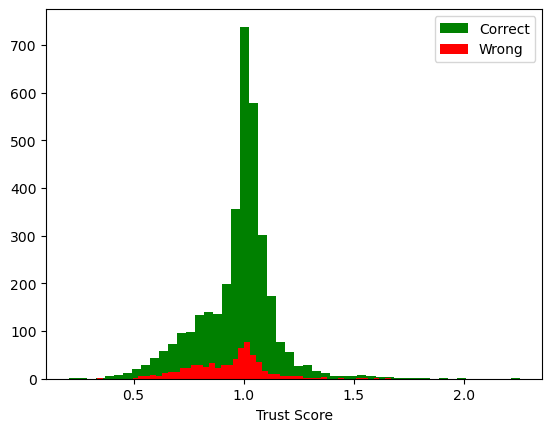

In [26]:
plot_histogram(correct, wrong, args, "input_images")

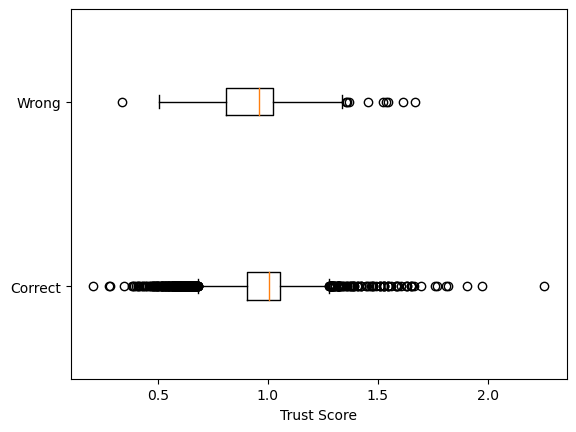

In [27]:
plot_boxplot(correct, wrong, args, "input_images")

[   1    2    3 ... 4105 4106 4108]
Precision at percentile 0.0
Model Confidence: 0.8425  Trust Score: 0.8425  

Precision at percentile 0.5
Model Confidence: 0.8454  Trust Score: 0.8420  

Precision at percentile 1.0
Model Confidence: 0.8483  Trust Score: 0.8417  

Precision at percentile 1.5
Model Confidence: 0.8503  Trust Score: 0.8416  

Precision at percentile 2.0
Model Confidence: 0.8527  Trust Score: 0.8425  

Precision at percentile 2.5
Model Confidence: 0.8545  Trust Score: 0.8425  

Precision at percentile 3.0
Model Confidence: 0.8567  Trust Score: 0.8429  

Precision at percentile 3.5
Model Confidence: 0.8588  Trust Score: 0.8436  

Precision at percentile 4.0
Model Confidence: 0.8608  Trust Score: 0.8431  

Precision at percentile 4.5
Model Confidence: 0.8626  Trust Score: 0.8435  

Precision at percentile 5.0
Model Confidence: 0.8645  Trust Score: 0.8435  

Precision at percentile 5.5
Model Confidence: 0.8666  Trust Score: 0.8442  

Precision at percentile 6.0
Model Confid

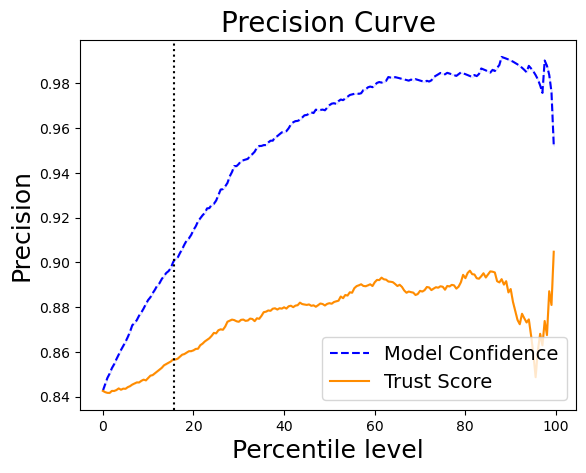

In [28]:
get_precision_curve(predictions, targets, test_embeddings, args, "input_images")

### 2. Trust score with final embeddings

In [271]:
# Initialize trust score.
trust_model = TrustScore(filtering="none")
trust_model.fit(train_embeddings[10:1010], train_targets[10:1010])

In [272]:
# Compute trusts score, given (unlabeled) testing examples and (hard) model predictions.
trust_scores = trust_model.get_score(test_embeddings, predictions)

100%|███████████████████████████████████████████| 17/17 [00:03<00:00,  4.30it/s]


In [273]:
correct = []
wrong = []
for i, score in enumerate(trust_scores):
    if predictions[i] == targets[i]:
        correct.append(score)
    else:
        wrong.append(score)

In [274]:
recall_wrong, recall_correct = get_metrics(correct, wrong)

How often if the score is lower than the mean trust score for incorrect cases, is the prediction wrong: 330
RoU = 0.5100463678516228
How often if the score is lower than the mean trust score for incorrect cases, is the prediction correct: 1011
FUR = 0.2920277296360485


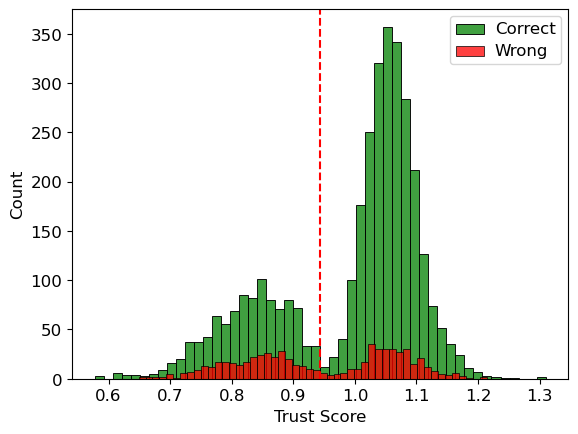

In [275]:
plot_histogram(correct, wrong, args, "final_embedding")

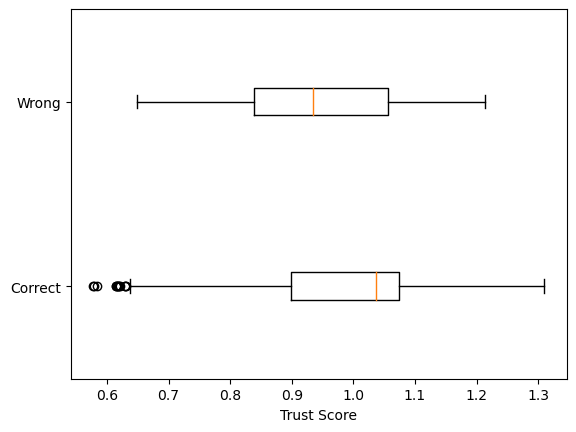

In [276]:
plot_boxplot(correct, wrong, args, "final_embedding")

[   1    2    3 ... 4105 4106 4108]
Precision at percentile 0.0
Model Confidence: 0.8425  Trust Score: 0.8425  

Precision at percentile 0.5
Model Confidence: 0.8454  Trust Score: 0.8422  

Precision at percentile 1.0
Model Confidence: 0.8483  Trust Score: 0.8431  

Precision at percentile 1.5
Model Confidence: 0.8503  Trust Score: 0.8436  

Precision at percentile 2.0
Model Confidence: 0.8527  Trust Score: 0.8433  

Precision at percentile 2.5
Model Confidence: 0.8545  Trust Score: 0.8437  

Precision at percentile 3.0
Model Confidence: 0.8567  Trust Score: 0.8439  

Precision at percentile 3.5
Model Confidence: 0.8588  Trust Score: 0.8439  

Precision at percentile 4.0
Model Confidence: 0.8608  Trust Score: 0.8446  

Precision at percentile 4.5
Model Confidence: 0.8626  Trust Score: 0.8456  

Precision at percentile 5.0
Model Confidence: 0.8645  Trust Score: 0.8460  

Precision at percentile 5.5
Model Confidence: 0.8666  Trust Score: 0.8468  

Precision at percentile 6.0
Model Confid

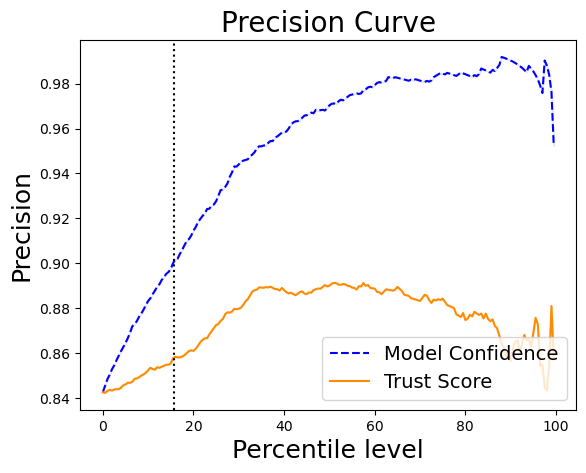

In [277]:
get_precision_curve(predictions, targets, test_embeddings, args, "final_embedding")

### 3. Trust score with weighted final embeddings by shapley values

In [278]:
# Initialize trust score.
trust_model = TrustScore(filtering="none")
trust_model.fit(shap_for_pred_train * train_embeddings[10:1010], train_targets[10:1010])

In [279]:
# Compute trusts score, given (unlabeled) testing examples and (hard) model predictions.
trust_scores = trust_model.get_score(shap_for_pred_test * test_embeddings, predictions)

100%|███████████████████████████████████████████| 17/17 [00:03<00:00,  4.37it/s]


In [280]:
correct = []
wrong = []
for i, score in enumerate(trust_scores):
    if predictions[i] == targets[i]:
        correct.append(score)
    else:
        wrong.append(score)

In [281]:
recall_wrong, recall_correct = get_metrics(correct, wrong)

How often if the score is lower than the mean trust score for incorrect cases, is the prediction wrong: 346
RoU = 0.5347758887171561
How often if the score is lower than the mean trust score for incorrect cases, is the prediction correct: 1091
FUR = 0.3151357596764876


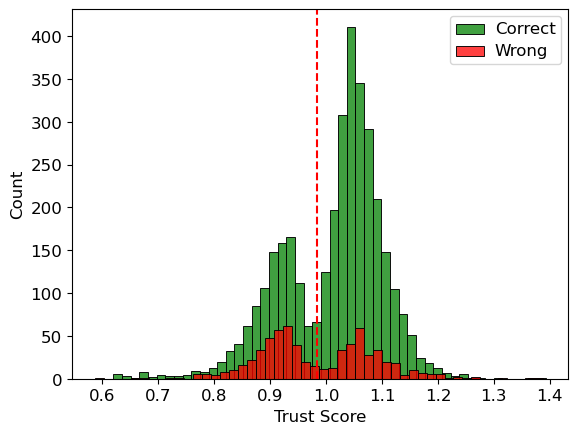

In [282]:
plot_histogram(correct, wrong, args, "weighted_shap_embedding")

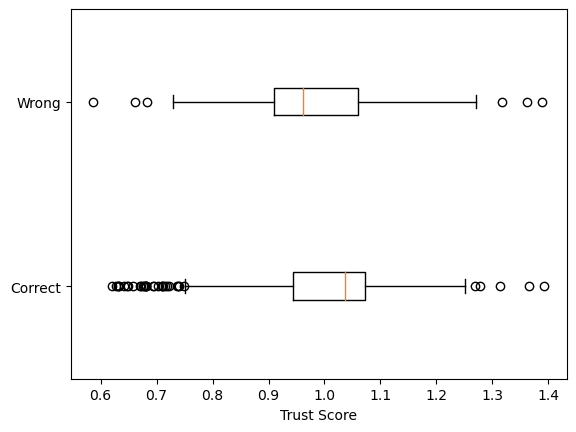

In [283]:
plot_boxplot(correct, wrong, args, "weighted_shap_embedding")

[   1    2    3 ... 4105 4106 4108]
Precision at percentile 0.0
Model Confidence: 0.8425  Trust Score: 0.8425  

Precision at percentile 0.5
Model Confidence: 0.8454  Trust Score: 0.8425  

Precision at percentile 1.0
Model Confidence: 0.8483  Trust Score: 0.8424  

Precision at percentile 1.5
Model Confidence: 0.8503  Trust Score: 0.8436  

Precision at percentile 2.0
Model Confidence: 0.8527  Trust Score: 0.8440  

Precision at percentile 2.5
Model Confidence: 0.8545  Trust Score: 0.8442  

Precision at percentile 3.0
Model Confidence: 0.8567  Trust Score: 0.8447  

Precision at percentile 3.5
Model Confidence: 0.8588  Trust Score: 0.8449  

Precision at percentile 4.0
Model Confidence: 0.8608  Trust Score: 0.8456  

Precision at percentile 4.5
Model Confidence: 0.8626  Trust Score: 0.8461  

Precision at percentile 5.0
Model Confidence: 0.8645  Trust Score: 0.8465  

Precision at percentile 5.5
Model Confidence: 0.8666  Trust Score: 0.8468  

Precision at percentile 6.0
Model Confid

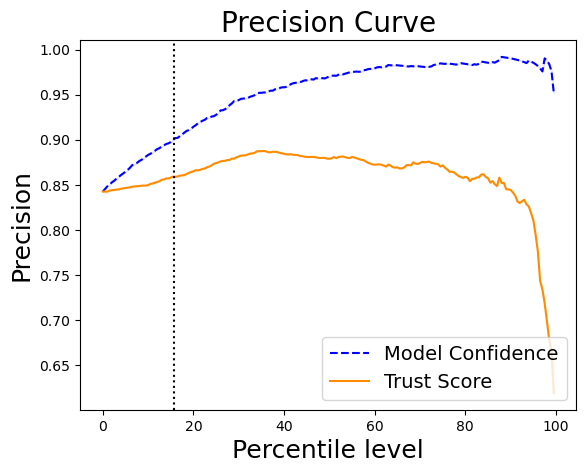

In [284]:
get_precision_curve(predictions, targets, test_embeddings, args, "weighted_shap_embedding")

### 4. Trust score with masked final embeddings by shapley values

In [248]:
mask_test = np.array([np.where(vect < 0, -1, 1) for vect in shap_for_pred_test])
mask_train = np.array([np.where(vect < 0, -1, 1) for vect in shap_for_pred_train])

In [249]:
# Initialize trust score.
trust_model = TrustScore(filtering="none")
trust_model.fit((mask_train * shap_for_pred_train) * train_embeddings[10:1010], train_targets[10:1010])

In [250]:
# Compute trusts score, given (unlabeled) testing examples and (hard) model predictions.
trust_scores = trust_model.get_score((mask_test * shap_for_pred_test) * test_embeddings, predictions)

100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.84it/s]


In [251]:
correct = []
wrong = []
for i, score in enumerate(trust_scores):
    if predictions[i] == targets[i]:
        correct.append(score)
    else:
        wrong.append(score)

In [252]:
recall_wrong, recall_correct = get_metrics(correct, wrong)

How often if the score is lower than the mean trust score for incorrect cases, is the prediction wrong: 393
RoU = 0.6093023255813953
How often if the score is lower than the mean trust score for incorrect cases, is the prediction correct: 1190
FUR = 0.3435334872979215


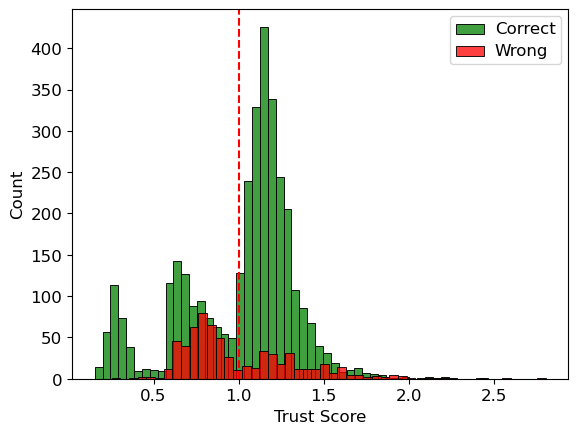

In [255]:
plot_histogram(correct, wrong, args, "masked_shap_embedding")

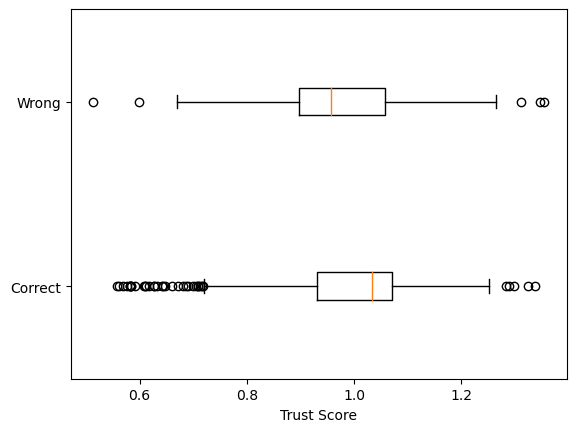

In [165]:
plot_boxplot(correct, wrong, args, "masked_shap_embedding")

[   1    2    3 ... 4105 4106 4108]
Precision at percentile 0.0
Model Confidence: 0.8425  Trust Score: 0.8425  

Precision at percentile 0.5
Model Confidence: 0.8454  Trust Score: 0.8422  

Precision at percentile 1.0
Model Confidence: 0.8483  Trust Score: 0.8426  

Precision at percentile 1.5
Model Confidence: 0.8503  Trust Score: 0.8431  

Precision at percentile 2.0
Model Confidence: 0.8527  Trust Score: 0.8438  

Precision at percentile 2.5
Model Confidence: 0.8545  Trust Score: 0.8442  

Precision at percentile 3.0
Model Confidence: 0.8567  Trust Score: 0.8444  

Precision at percentile 3.5
Model Confidence: 0.8588  Trust Score: 0.8446  

Precision at percentile 4.0
Model Confidence: 0.8608  Trust Score: 0.8451  

Precision at percentile 4.5
Model Confidence: 0.8626  Trust Score: 0.8453  

Precision at percentile 5.0
Model Confidence: 0.8645  Trust Score: 0.8455  

Precision at percentile 5.5
Model Confidence: 0.8666  Trust Score: 0.8460  

Precision at percentile 6.0
Model Confid

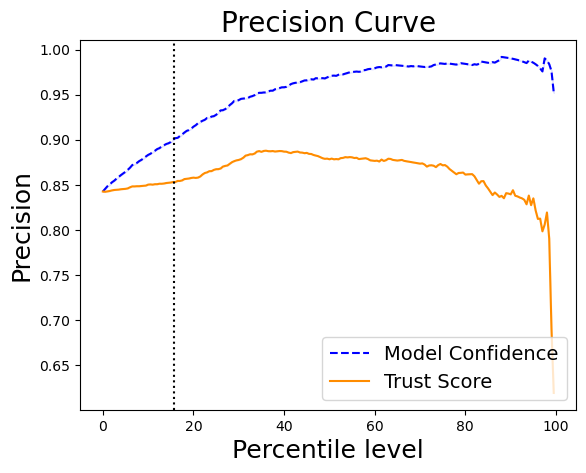

In [166]:
get_precision_curve(predictions, targets, test_embeddings, args, "masked_shap_embedding")

### 5. Trust score with reduced dimensionality final embeddings by shapley values

In [167]:
sorted_indices = np.argsort(shap_for_pred_train, axis=1)
mx = sorted_indices[:,:20]
mn = sorted_indices[:,-20:]
reduction_train = np.hstack((mn, mx))
reduction_train.shape

(1000, 40)

In [168]:
sorted_indices = np.argsort(shap_for_pred_test, axis=1)
mx = sorted_indices[:,:20]
mn = sorted_indices[:,-20:]
reduction_test = np.hstack((mn, mx))
reduction_test.shape

(4109, 40)

In [169]:
reduced_shap_vectors_train = []
sim_vector_train = shap_for_pred_train * train_embeddings[10:1010]

for index, vector in enumerate(sim_vector_train): #number of test samples
    reduced_shap_vectors_train.append(vector[reduction_train[index]]) # get with the reduction indices the values from the shap vectors
    
reduced_shap_vectors_train = np.array(reduced_shap_vectors_train)

In [170]:
reduced_shap_vectors_test = []
sim_vector_test = shap_for_pred_test * test_embeddings

for index, vector in enumerate(sim_vector_test): #number of test samples
    reduced_shap_vectors_test.append(vector[reduction_test[index]]) # get with the reduction indices the values from the shap vectors
    
reduced_shap_vectors_test = np.array(reduced_shap_vectors_test)

In [171]:
# Initialize trust score.
trust_model = TrustScore(filtering="none")
trust_model.fit(reduced_shap_vectors_train, train_targets[10:1010])

In [172]:
# Compute trusts score, given (unlabeled) testing examples and (hard) model predictions.
trust_scores = trust_model.get_score(reduced_shap_vectors_test, predictions)

100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 64.92it/s]


In [173]:
correct = []
wrong = []
for i, score in enumerate(trust_scores):
    if predictions[i] == targets[i]:
        correct.append(score)
    else:
        wrong.append(score)

In [174]:
recall_wrong, recall_correct = get_metrics(correct, wrong)

How often if the score is lower than the mean trust score for incorrect cases, is the prediction wrong: 338
RoU = 0.5224111282843895
How often if the score is lower than the mean trust score for incorrect cases, is the prediction correct: 985
FUR = 0.28451761987290586


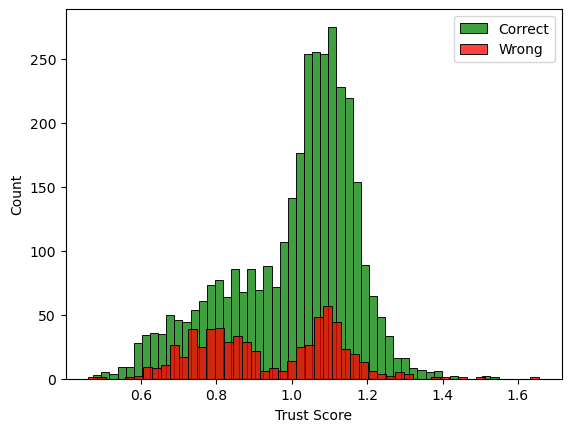

In [175]:
plot_histogram(correct, wrong, args, "reduced_shap_embedding")

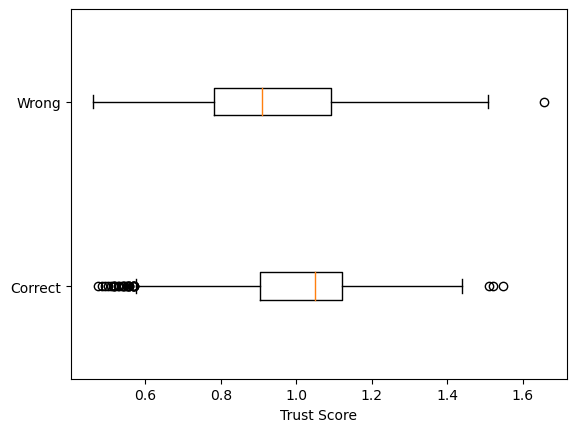

In [176]:
plot_boxplot(correct, wrong, args, "reduced_shap_embedding")

[   1    2    3 ... 4105 4106 4108]
Precision at percentile 0.0
Model Confidence: 0.8425  Trust Score: 0.8425  

Precision at percentile 0.5
Model Confidence: 0.8454  Trust Score: 0.8422  

Precision at percentile 1.0
Model Confidence: 0.8483  Trust Score: 0.8419  

Precision at percentile 1.5
Model Confidence: 0.8503  Trust Score: 0.8414  

Precision at percentile 2.0
Model Confidence: 0.8527  Trust Score: 0.8413  

Precision at percentile 2.5
Model Confidence: 0.8545  Trust Score: 0.8412  

Precision at percentile 3.0
Model Confidence: 0.8567  Trust Score: 0.8414  

Precision at percentile 3.5
Model Confidence: 0.8588  Trust Score: 0.8414  

Precision at percentile 4.0
Model Confidence: 0.8608  Trust Score: 0.8418  

Precision at percentile 4.5
Model Confidence: 0.8626  Trust Score: 0.8423  

Precision at percentile 5.0
Model Confidence: 0.8645  Trust Score: 0.8422  

Precision at percentile 5.5
Model Confidence: 0.8666  Trust Score: 0.8424  

Precision at percentile 6.0
Model Confid

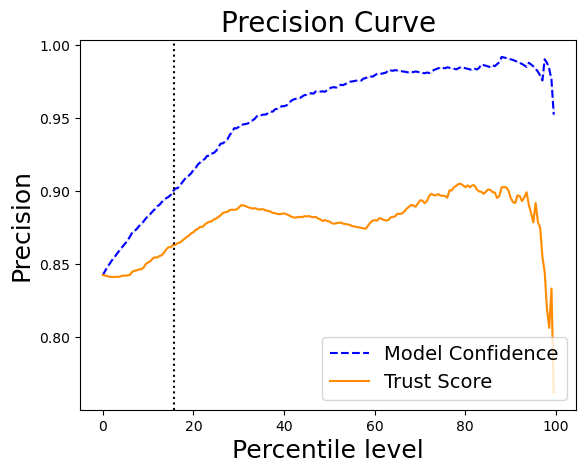

In [177]:
get_precision_curve(predictions, targets, test_embeddings, args, "reduced_shap_embedding")